In [75]:
import datetime
import warnings
import re
import gc
import os    

#import pickle

import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay

In [76]:
gpu = tf.config.experimental.list_physical_devices(device_type='GPU')
assert len(gpu) == 1
tf.config.experimental.set_memory_growth(gpu[0], True)

# hyperparameters

In [77]:
settings = {
    "units": 128,
    "hidden_layers": 5,
    "lr": 0.0001,
    "patience": 20,
    "batch_size": 1024,
    "epochs_num":1000,
}

# Data

In [78]:
#path = "../input/lstm100num/LSTM_TOUGH/"
path = "../input/lstm100num/input/"
file_list = os.listdir(path)
trn_data = []
val_data = []
time_steps = 11
print(len(file_list))

trn_size = int(len(file_list) * 0.8)
for file in file_list[:trn_size]:
    data_tmp = np.genfromtxt(path + file).T
    for row in range(len(data_tmp) - time_steps):
        trn_data.append(np.expand_dims(data_tmp[row:row + time_steps], axis=0))

for file in file_list[trn_size:]:
    data_tmp = np.genfromtxt(path + file).T
    for row in range(len(data_tmp) - time_steps):
        val_data.append(np.expand_dims(data_tmp[row:row + time_steps], axis=0))

10


In [79]:
trn_data = np.concatenate(trn_data, axis=0)
val_data = np.concatenate(val_data, axis=0)

num_trn, _, num_feat = trn_data.shape
num_val, _, _ = val_data.shape

In [80]:
trn_data = trn_data.reshape([-1, num_feat])
val_data = val_data.reshape([-1, num_feat])

trn_mean = np.mean(trn_data, axis=0)
trn_std = np.std(trn_data, axis=0)
trn_data = (trn_data - trn_mean) / trn_std
val_data = (val_data - trn_mean) / trn_std

trn_data = trn_data.reshape([num_trn, time_steps, num_feat])
val_data = val_data.reshape([num_val, time_steps, num_feat])

In [81]:
settings["trg_num"] = trn_data.shape[-1]

In [82]:
trn_x = trn_data[:, :time_steps]
trn_y = trn_data[:, -1]

val_x = val_data[:, :time_steps]
val_y = val_data[:, -1]

settings["input_shape"] = trn_x.shape[1:]

In [83]:
def make_dataset(feature, y, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices((feature, y))
    ds = ds.shuffle(2*batch_size).batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [84]:
trn_ds = make_dataset(trn_x, trn_y)
val_ds = make_dataset(val_x, val_y)

# Model

In [85]:
def get_model(settings):
    seq = []
    seq.append(
        tf.keras.layers.LSTM(settings["units"],
                             recurrent_regularizer=tf.keras.regularizers.l1_l2(
                                 l1=0, l2=0.01),
                             return_sequences=True,
                             activation='tanh',
                             input_shape=settings["input_shape"]))
    for i in range(settings["hidden_layers"]):
        seq.append(
            tf.keras.layers.LSTM(
                settings["units"],
                recurrent_regularizer=tf.keras.regularizers.l1_l2(l1=0,
                                                                  l2=0.01),
                return_sequences=True,
                activation='tanh'))

    seq.append(
        tf.keras.layers.LSTM(settings["units"],
                             recurrent_regularizer=tf.keras.regularizers.l1_l2(
                                 l1=0, l2=0.01),
                             return_sequences=False,
                             activation='tanh'))

    seq.append(tf.keras.layers.Dense(settings["trg_num"]))

    model = tf.keras.models.Sequential(seq)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=settings["lr"]),
        loss="mse")
    return model

In [86]:
model = get_model(settings)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 11, 128)           132608    
_________________________________________________________________
lstm_29 (LSTM)               (None, 11, 128)           131584    
_________________________________________________________________
lstm_30 (LSTM)               (None, 11, 128)           131584    
_________________________________________________________________
lstm_31 (LSTM)               (None, 11, 128)           131584    
_________________________________________________________________
lstm_32 (LSTM)               (None, 11, 128)           131584    
_________________________________________________________________
lstm_33 (LSTM)               (None, 11, 128)           131584    
_________________________________________________________________
lstm_34 (LSTM)               (None, 128)              

In [87]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=settings["patience"], mode='min')
ckpt = tf.keras.callbacks.ModelCheckpoint('./checkpoint',
                                          monitor='val_loss',
                                          verbose=0,
                                          save_best_only=True,
                                          save_weights_only=True)

history = model.fit(trn_ds,
    batch_size=settings["batch_size"],
    epochs=settings["epochs_num"],
    shuffle=True,  #默认为True,在每一个batch里面进行shuffle
    verbose=2,
    validation_data=val_ds,
    callbacks=[early_stopping, ckpt])

model.load_weights("./checkpoint")

Epoch 1/1000
2/2 - 10s - loss: 9.7771 - val_loss: 9.2979
Epoch 2/1000
2/2 - 0s - loss: 9.7124 - val_loss: 9.2336
Epoch 3/1000
2/2 - 0s - loss: 9.6479 - val_loss: 9.1697
Epoch 4/1000
2/2 - 0s - loss: 9.5837 - val_loss: 9.1062
Epoch 5/1000
2/2 - 0s - loss: 9.5199 - val_loss: 9.0431
Epoch 6/1000
2/2 - 0s - loss: 9.4565 - val_loss: 8.9803
Epoch 7/1000
2/2 - 0s - loss: 9.3933 - val_loss: 8.9179
Epoch 8/1000
2/2 - 0s - loss: 9.3305 - val_loss: 8.8559
Epoch 9/1000
2/2 - 0s - loss: 9.2679 - val_loss: 8.7942
Epoch 10/1000
2/2 - 0s - loss: 9.2056 - val_loss: 8.7328
Epoch 11/1000
2/2 - 0s - loss: 9.1435 - val_loss: 8.6718
Epoch 12/1000
2/2 - 0s - loss: 9.0816 - val_loss: 8.6111
Epoch 13/1000
2/2 - 0s - loss: 9.0198 - val_loss: 8.5507
Epoch 14/1000
2/2 - 0s - loss: 8.9581 - val_loss: 8.4906
Epoch 15/1000
2/2 - 0s - loss: 8.8964 - val_loss: 8.4306
Epoch 16/1000
2/2 - 0s - loss: 8.8346 - val_loss: 8.3708
Epoch 17/1000
2/2 - 0s - loss: 8.7727 - val_loss: 8.3112
Epoch 18/1000
2/2 - 0s - loss: 8.7104 -

# Validation

In [88]:
def myMase(pred, true, m=1):
    '''m是周期长度'''
    return np.mean(np.abs(pred-true))/np.mean(np.abs(true[m:] - true[:-m]))

def myRmse(pred, true):
    return np.sqrt(np.mean(np.square(pred-true)))

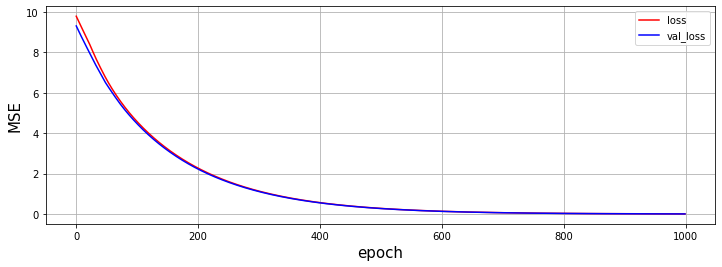

In [89]:
pd.DataFrame(history.history)[[
    'loss', 'val_loss'
]].plot(figsize=(12, 4), color=['r', 'b'])
plt.grid(True)
#plt.gca().set_ylim(0,60)
plt.xlabel('epoch', fontsize=15)
plt.ylabel('MSE', fontsize=15)
#plt.title('9-16-0.0063-500',fontsize=25)
plt.show()

In [90]:
pred_trn = model.predict(trn_x, verbose=0)
mase1 = myMase(pred_trn, trn_y)
print(mase1)
rmse1 = myRmse(pred_trn, trn_y)
print(rmse1)
print(myRmse(trn_y[:-1], trn_y[1:]))

0.8741877537897781
0.04673756963086674
0.20021380426684598


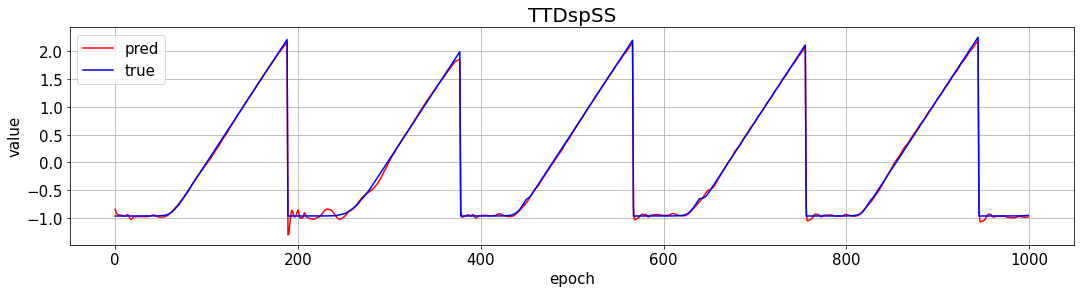

In [91]:
for i, feat in enumerate(['TTDspSS']):
    tmp = pd.DataFrame(
        np.concatenate([pred_trn[:1000, i:i + 1], trn_y[:1000, i:i + 1]], axis=1))
    tmp.columns = ['pred', 'true']

    tmp.plot(figsize=(18, 4), color=['r', 'b'])
    plt.grid(True)
    plt.xlabel('epoch', fontsize=15)
    plt.ylabel('value', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(feat, fontsize=20)
    plt.legend(fontsize=15)
    plt.show()

In [92]:
pred_val = model.predict(val_x, verbose=0)
mase2 = myMase(pred_val, val_y)
print(mase2)
rmse2 = myRmse(pred_val, val_y)
print(rmse2)
print(myRmse(val_y[:-1], val_y[1:]))

0.9801872253383941
0.03662481045780774
0.14175252334518584


**保存**

In [93]:
tf.saved_model.save(model, './')     #保存模型

#def save_variable(v,filename):
#    f=open(filename,'wb')          #打开或创建名叫filename的文档。
#    pickle.dump(v,f)               #在文件filename中写入v
#    f.close()                      #关闭文件，释放内存。
#    return filename

#save_variable(pred_trn,'./pred_trn0')
#save_variable(trn_y,'./trn_y0')
#save_variable(pred_val,'./pred_val0')
#save_variable(val_y,'./val_y0')
#保存数据
pred_trn0= pd.DataFrame(
        np.concatenate([pred_trn], axis=1))
pred_trn0.to_csv('./pred_tr.csv')

trn_y0= pd.DataFrame(
        np.concatenate([trn_y], axis=1))
trn_y0.to_csv('./true_tr0.csv')

pred_val0= pd.DataFrame(
        np.concatenate([pred_val], axis=1))
pred_val0.to_csv('./pred_test0.csv')

val_y0= pd.DataFrame(
        np.concatenate([val_y], axis=1))
val_y0.to_csv('./test_y0.csv')

meandata= pd.DataFrame(
        np.concatenate([trn_mean,trn_std], axis=0))
meandata.to_csv('./meandata.csv')

print(trn_std)

[2.78526717e+07 3.30718914e+05 7.50000000e+00 5.90777972e+00
 9.02246686e+05 9.27912507e+05 9.51927526e+05 9.75295572e+05
 9.98307270e+05 1.02110388e+06 1.04380115e+06 1.06646438e+06
 1.08917465e+06 1.11202460e+06 1.13503417e+06 1.15829644e+06
 1.18180630e+06 1.20562816e+06 1.22976191e+06 1.25431544e+06
 1.27925490e+06 1.30463064e+06 1.33048222e+06 1.35679157e+06
 1.38361230e+06 1.41095375e+06 1.43887695e+06 1.46737149e+06
 1.49641959e+06 1.52602954e+06 1.55634611e+06 1.58726277e+06
 1.61879355e+06 1.65097950e+06 1.68370704e+06 1.59550773e+06
 1.34631412e+06 1.27251813e+06 1.16635660e+06 1.09285902e+06
 1.02449577e+06 9.76714556e+05 7.18361115e+05 6.04939074e+05
 5.25307068e+05 5.15134515e+05 7.50000000e+00 7.19039827e+00
 6.95343224e+00 6.71042563e+00 6.48152140e+00 6.26928756e+00
 6.07259201e+00 5.88675840e+00 5.71283018e+00 5.54825744e+00
 5.39234088e+00 5.24397216e+00 5.10126708e+00 4.96472650e+00
 4.83405800e+00 4.70827287e+00 4.58730311e+00 4.47082972e+00
 4.35886439e+00 4.251712